In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
import xarray as xr

import matplotlib.pyplot as plt

from itertools import product

from uavsar_pytools.snow_depth_inversion import phase_from_depth, depth_from_phase

plt.style.use(Path('~/uavsar-validation/manuscript.mplstyle'))

In [2]:
swe = 0.1 # 10 centimeters of water
dens = np.arange(100, 200, 5)
incs = np.arange(30, 65, 1)
phases = np.zeros(dens.size * incs.size)
for j, (d, i) in enumerate(product(dens, incs)):
    h = swe * d / 997
    phases[j] = phase_from_depth(h, np.deg2rad(i), density=d)


In [3]:
inc = 45
hs = np.arange(1, 30, 1) / 100
phases = np.zeros(hs.size * dens.size)
for i, (h, d) in enumerate(product(hs, dens)):
    phases[i] = phase_from_depth(h, np.deg2rad(inc), density=d)
phases = phases.reshape(hs.size, dens.size)
# phases = np.flipud(phases.T)

In [4]:
swe = 0.1 # 10 centimeters of water
inc = 45
phases = np.zeros(dens.size)
for i, d in enumerate(dens):
    h = swe * d / 997
    phases[i] = phase_from_depth(h, np.deg2rad(inc), density = d)

In [5]:
# den_low = 100
# den_high = 300
# swes = np.arange(0, 0.06, 0.001)
# inc = np.arange(30, 65, 1)
# phases = np.zeros(swes.size * inc.size)

# for j, (swe, i) in enumerate(product(swes, inc)):
#     h = swe / den_low * 997
#     phases[j] = phase_from_depth(h, np.deg2rad(i), density = den_low)
# phases = phases.reshape(swes.size, inc.size)
# from mpl_toolkits.axes_grid1 import make_axes_locatable

# fig, ax = plt.subplots(figsize = (12, 8))
# divider = make_axes_locatable(ax)
# cax = divider.append_axes('right', size='5%', pad=0.05)

# im = ax.imshow(phases, aspect= 'auto', extent = [swes[0], swes[-1], inc[0], inc[-1]])
# fig.colorbar(im, cax = cax)

# # ax.contour([])

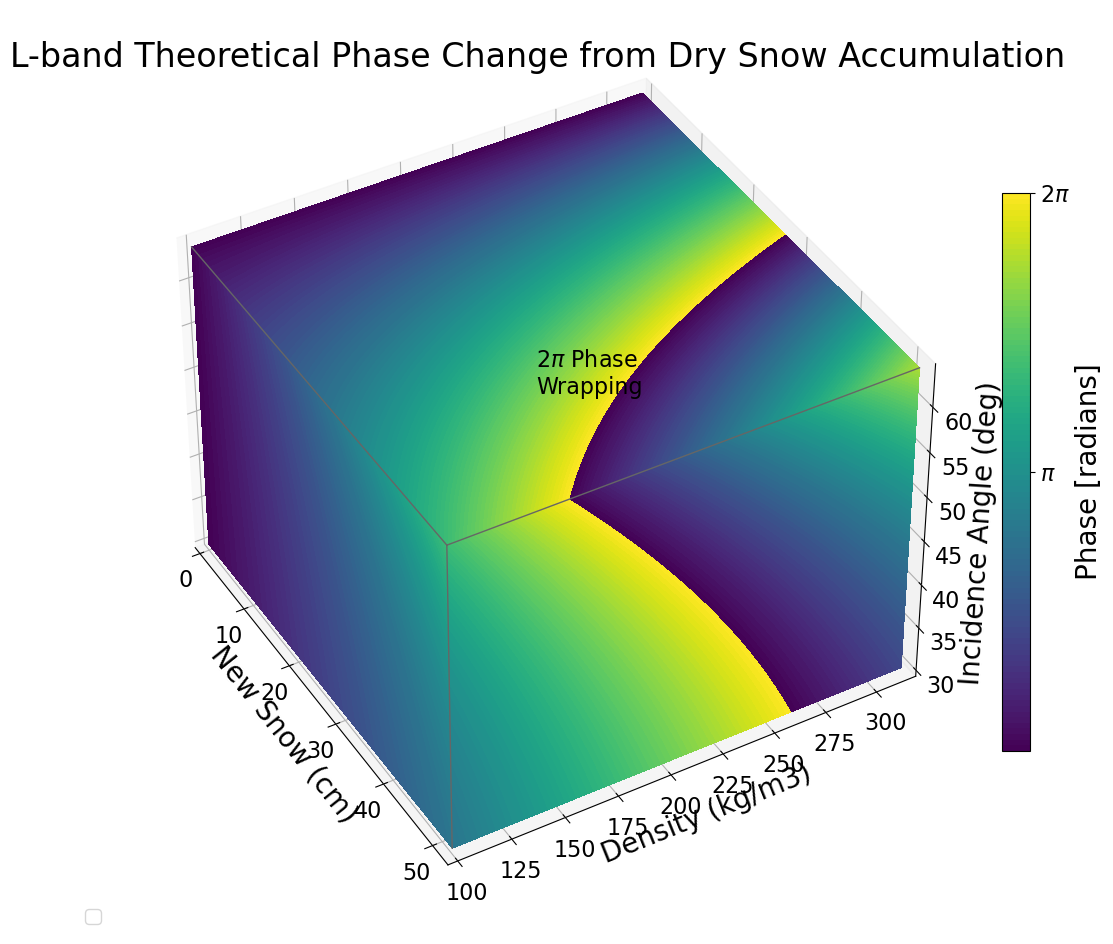

In [6]:
inc = np.arange(30, 65, 1)
den = np.arange(100, 320, 5)
hn = np.arange(0, 0.53, 0.01)*100
swe = np.zeros(den.size*hn.size*inc.size)
phases = np.zeros(den.size*hn.size*inc.size)
for j, (h, d, i) in enumerate(product(hn, den, inc)):
    phases[j] = phase_from_depth(h/100, np.deg2rad(i), density=d) 
    
data = phases.reshape(hn.size, den.size, inc.size)
X, Y, Z = np.meshgrid(hn, den, inc)

kw = {
    'vmin': 0,
    'vmax': 2*np.pi,
    
    'levels': np.linspace(0, 2*np.pi, 100),
    'cmap':'viridis'
}
kw2 = {
    'vmin': 2*np.pi,
    'vmax': 4*np.pi,
    
    'levels': np.linspace(2*np.pi,4*np.pi, 100),
    'cmap':'viridis'
}

# Create a figure with 3D ax
fig = plt.figure(figsize=(18, 12))
ax = fig.add_subplot(111, projection='3d')

# Plot contour surfaces
# surface on top of box
_ = ax.contourf(
    X[:, :, -1], Y[:, :, 0], data[:, :, -1].T,
    zdir='z', offset=Z.max(), **kw
)
_ = ax.contourf(
    X[:, :, -1], Y[:, :, 0], data[:, :, -1].T,
    zdir='z', offset=Z.max(), **kw2
)
# _ = ax.contour(
#     X[:, :, -1], Y[:, :, 0], data[:, :, -1].T, [2* np.pi],
#     zdir='z', offset=Z.max(), colors= ['C1'], linestyles = 'dashed'
# )
# y and z axis side
_ = ax.contourf(
    X[0, :, :], data[:, 0, :], Z[0, :, :],
    zdir='y', offset=Y.min(), **kw
)

C = ax.contourf(
    data[-1, :, :], Y[:, -1, :], Z[:, -1, :],
    zdir='x', offset=X.max(), **kw
)
_ = ax.contourf(
    data[-1, :, :], Y[:, -1, :], Z[:, -1, :],
    zdir='x', offset=X.max(), **kw2
)
# _ = ax.contour(
#     data[-1, :, :], Y[:, -1, :], Z[:, -1, :], [2* np.pi],
#     zdir='x', offset=X.max(), colors= ['C1'], linestyles = 'dashed'
# )

# Set limits of the plot from coord limits
xmin, xmax = X.min(), X.max()
ymin, ymax = Y.min(), Y.max()
zmin, zmax = Z.min(), Z.max()
ax.set(xlim=[xmin, xmax], ylim=[ymin, ymax], zlim=[zmin, zmax])

# Plot edges
edges_kw = dict(linewidth=1, zorder=1e3, color = '0.4')
# line @ z = 0 along y axis
# ax.plot([xmax, xmax], [ymin, ymax], zmin, **edges_kw)
ax.plot([xmax, xmax], [ymin, ymax], zmax, **edges_kw)
# line @ z = 0 along x axis
# ax.plot([xmin, xmax], [ymin, ymin], zmin, **edges_kw)
ax.plot([xmin, xmax], [ymin, ymin], zmax, **edges_kw)
# line @ x max and y min along z axis
ax.plot([xmax, xmax], [ymin, ymin], [zmin, zmax], **edges_kw)
# ax.plot([0,0],[0,0],[0,0], label = '2$\pi$ Wrap', color = 'C1', linestyle = 'dashed')

# Set labels and zticks
ax.set(
    xlabel='New Snow (cm)',
    ylabel='Density (kg/m3)',
    zlabel='Incidence Angle (deg)',
    # zticks=[0, -150, -300, -450],
)

# Set zoom and angle view
ax.view_init(40, -30, 0)
ax.set_box_aspect(None, zoom=0.91)
ax.legend(loc = 'lower left')
# Colorbar
cbar = fig.colorbar(C, ax=ax, fraction=0.02, pad=0.002, label='Phase [radians]', ticks=[np.pi, 2*np.pi, 3*np.pi])
cbar.ax.set_yticklabels(['$\pi$', '2$\pi$','3$\pi$'])
# plt.tight_layout()
# Show Figure
ax.text(s = '$2\pi$ Phase\nWrapping', x = 37, y = 175, z = zmax, zorder = 1e3, weight = None)

ax.set_title('L-band Theoretical Phase Change from Dry Snow Accumulation', y = 1.01)



plt.savefig('/bsuhome/zacharykeskinen/uavsar-validation/figures/theoretical/l-band-phase-sd.png')

In [13]:
inc = np.arange(30, 65, 1)
den = np.arange(100, 320, 5)
hn = np.arange(0, 0.53, 0.01)*100
swe = np.zeros(den.size*hn.size*inc.size)
phases = np.zeros(den.size*hn.size*inc.size)
for j, (h, d, i) in enumerate(product(hn, den, inc)):
    phases[j] = phase_from_depth(h/100, np.deg2rad(i), density=d) 

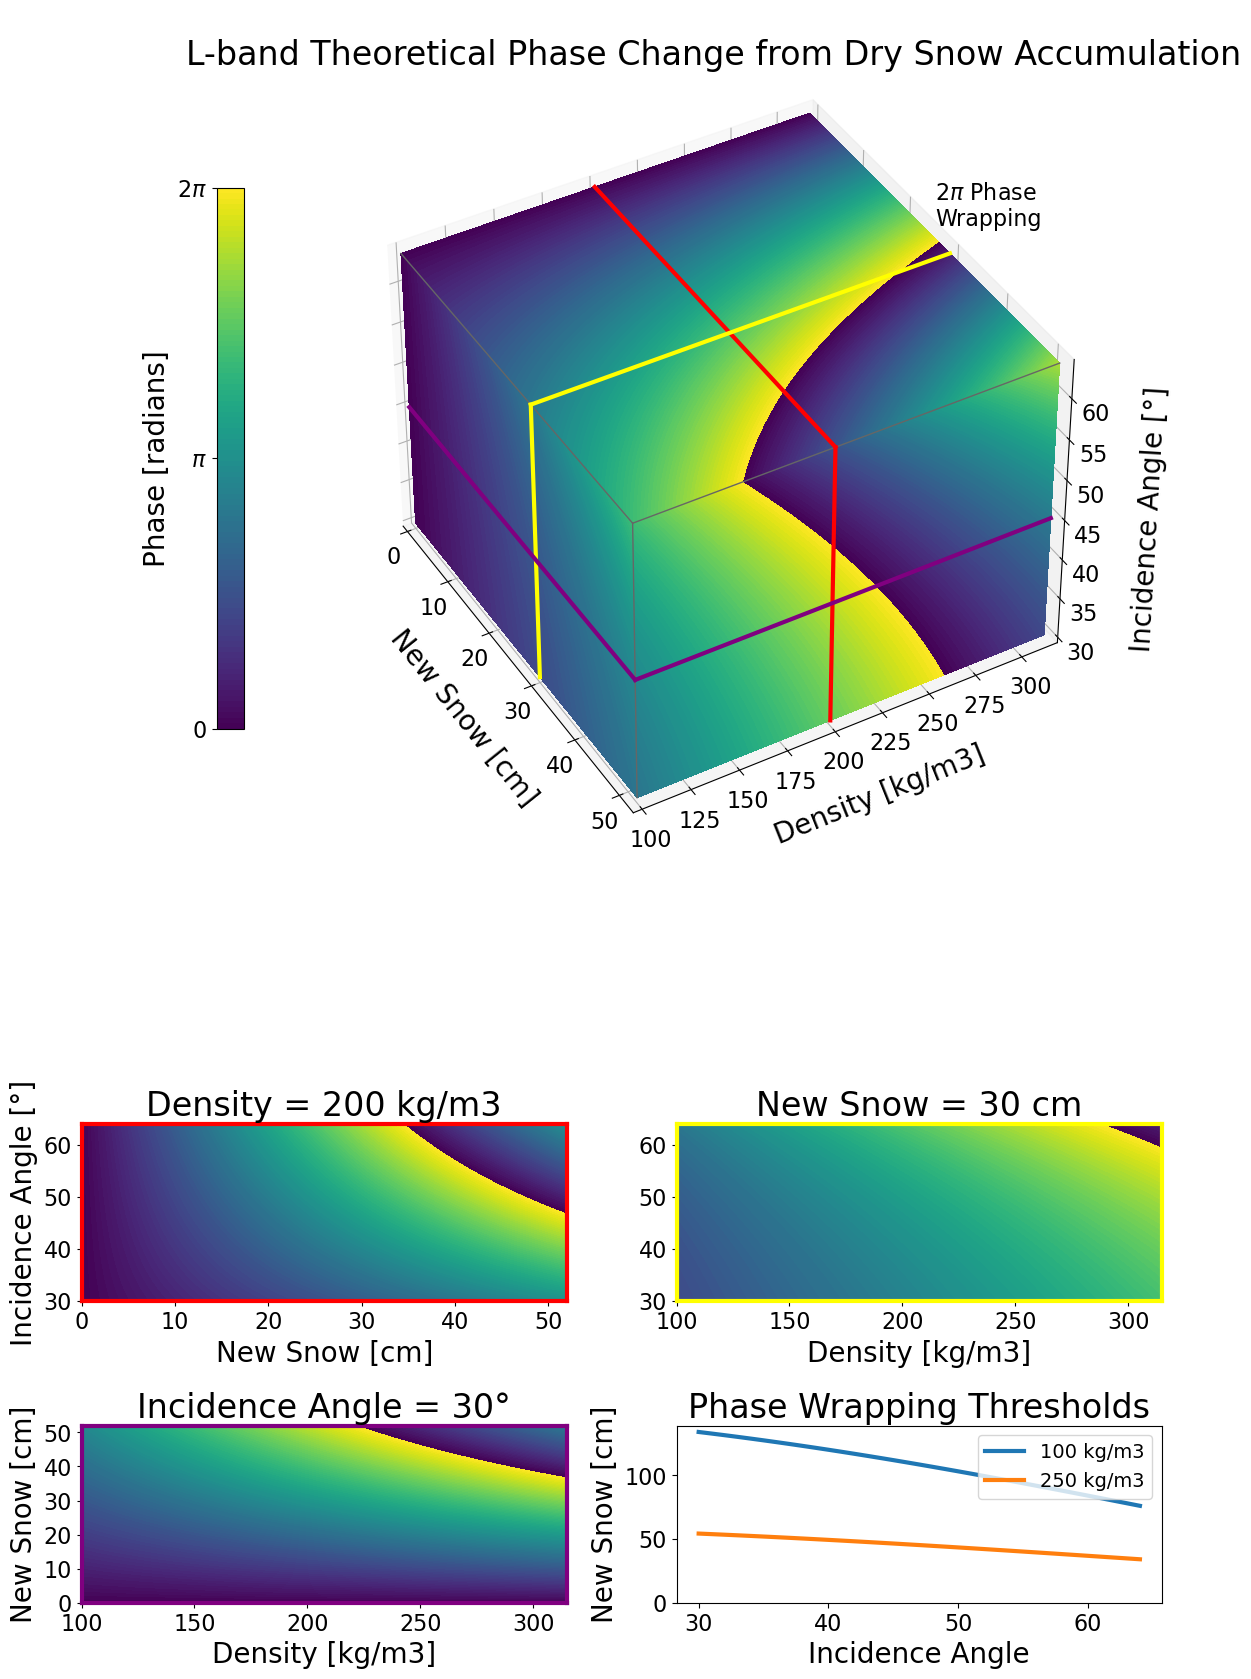

In [15]:
data = phases.reshape(hn.size, den.size, inc.size)
da = xr.DataArray(data, dims = ['hn', 'den', 'inc'], coords = [hn, den, inc])
X, Y, Z = np.meshgrid(hn, den, inc)

kw = {
    'vmin': 0,
    'vmax': 2*np.pi,
    
    'levels': np.linspace(0, 2*np.pi, 100),
    'cmap':'viridis'
}
kw2 = {
    'vmin': 2*np.pi,
    'vmax': 4*np.pi,
    
    'levels': np.linspace(2*np.pi,4*np.pi, 100),
    'cmap':'viridis'
}

# Create a figure with 3D ax
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(12,18))
gs = gridspec.GridSpec(12, 4)

ax = plt.subplot(gs[:-4, :], projection = '3d')

ax2 = plt.subplot(gs[-4:-2, :2])

ax3 = plt.subplot(gs[-4:-2, 2:])

ax4 = plt.subplot(gs[-2:, :2])

ax5 = plt.subplot(gs[-2:, 2:])

# ax.annotate('Big Axes \nGridSpec[1:, -1]', (0.1, 0.5),
#                xycoords='axes fraction', va='center')
# Plot contour surfaces
# surface on top of box
_ = ax.contourf(
    X[:, :, -1], Y[:, :, 0], data[:, :, -1].T,
    zdir='z', offset=Z.max(), **kw
)
_ = ax.contourf(
    X[:, :, -1], Y[:, :, 0], data[:, :, -1].T,
    zdir='z', offset=Z.max(), **kw2
)
# _ = ax.contour(
#     X[:, :, -1], Y[:, :, 0], data[:, :, -1].T, [2* np.pi],
#     zdir='z', offset=Z.max(), colors= ['C1'], linestyles = 'dashed'
# )
# y and z axis side
_ = ax.contourf(
    X[0, :, :], data[:, 0, :], Z[0, :, :],
    zdir='y', offset=Y.min(), **kw
)

C = ax.contourf(
    data[-1, :, :], Y[:, -1, :], Z[:, -1, :],
    zdir='x', offset=X.max(), **kw
)
_ = ax.contourf(
    data[-1, :, :], Y[:, -1, :], Z[:, -1, :],
    zdir='x', offset=X.max(), **kw2
)
# _ = ax.contour(
#     data[-1, :, :], Y[:, -1, :], Z[:, -1, :], [2* np.pi],
#     zdir='x', offset=X.max(), colors= ['C1'], linestyles = 'dashed'
# )

# Set limits of the plot from coord limits
xmin, xmax = X.min(), X.max()
ymin, ymax = Y.min(), Y.max()
zmin, zmax = Z.min(), Z.max()
ax.set(xlim=[xmin, xmax], ylim=[ymin, ymax], zlim=[zmin, zmax])

# Plot edges
edges_kw = dict(linewidth=1, zorder=1e3, color = '0.4')
# line @ z = 0 along y axis
# ax.plot([xmax, xmax], [ymin, ymax], zmin, **edges_kw)
ax.plot([xmax, xmax], [ymin, ymax], zmax, **edges_kw)
# line @ z = 0 along x axis
# ax.plot([xmin, xmax], [ymin, ymin], zmin, **edges_kw)
ax.plot([xmin, xmax], [ymin, ymin], zmax, **edges_kw)
# line @ x max and y min along z axis
ax.plot([xmax, xmax], [ymin, ymin], [zmin, zmax], **edges_kw)
# ax.plot([0,0],[0,0],[0,0], label = '2$\pi$ Wrap', color = 'C1', linestyle = 'dashed')

# lines @ 200 kg/m3
ax.plot([xmin, xmax], [200, 200], [zmax, zmax], color = 'red', zorder = 1e3)
ax.plot([xmax, xmax], [200, 200], [zmin, zmax], color = 'red', zorder = 1e3)

# lines @ 20 cm
ax.plot([30, 30], [ymin, ymax], [zmax, zmax], color = 'yellow', zorder = 1e3)
ax.plot([30, 30], [ymin, ymin], [zmin, zmax], color = 'yellow', zorder = 1e3)

# lines @ 30 degrees
ax.plot([xmax, xmax], [ymin, ymax], [45, 45], color = 'purple', zorder = 1e3)
ax.plot([xmin, xmax], [ymin, ymin], [45, 45], color = 'purple', zorder = 1e3)

# Set labels and zticks
ax.set_xlabel('New Snow [cm]', labelpad = 20)
ax.set_ylabel('Density [kg/m3]', labelpad = 20)
ax.set_zlabel('Incidence Angle [°]', labelpad = 20)

# ax.set(
#     xlabel='New Snow [cm]',
#     ylabel='Density [kg/m3]',
#     zlabel='Incidence Angle [degrees]',
#     # zticks=[0, -150, -300, -450],
# )


# Set zoom and angle view
ax.view_init(40, -30, 0)
ax.set_box_aspect(None, zoom=0.85)
# ax.legend(loc = 'lower left')
# Colorbar
cbar = fig.colorbar(C, ax=ax, pad=0.02, shrink = 0.5, label='Phase [radians]', ticks=[0, np.pi, 2*np.pi], location = 'left')
cbar.ax.set_yticklabels(['0', '$\pi$', '2$\pi$'])
# plt.tight_layout()
# Show Figure
ax.text(s = '$2\pi$ Phase\nWrapping', x = 25, y = 320, z = zmax, zorder = 1e3, weight = None)
# ax.arrow([25, 29], [350, 300], [zmax, zmax])
# ax.quiver(25, 350, zmax, 4, -50, 0, color = 'red', alpha = .8, lw = 3, zorder = 1e5)

ax.set_title('L-band Theoretical Phase Change from Dry Snow Accumulation', y = 1.01)

# middle left density = 200 kg/m3
n = 20
C = ax2.contourf(data[:, :, n].T, extent = [X[0, 0, n], X[0, -1, n], Z[0, n, 0], Z[0, n, -1]], **kw)
ax2.contourf(data[:, :, n].T, extent = [X[0, 0, n], X[0, -1, n], Z[0, n, 0], Z[0, n, -1]], **kw2)

ax2.set_xticks(X[0, ::10, n])
ax2.set_xlabel('New Snow [cm]')
ax2.set_yticks(Z[0, n, ::10])
ax2.set_ylabel('Incidence Angle [°]')

ax2.set_title('Density = 200 kg/m3')

# middle right hn = 20 cm
n = 30
C = ax3.contourf(data[n, :, :].T, extent = [Y[0, 0, n], Y[-1, 0, n], Z[0, n, 0], Z[0, n, -1]], **kw)
ax3.contourf(data[n, :, :].T, extent = [Y[0, 0, n], Y[-1, 0, n], Z[0, n, 0], Z[0, n, -1]], **kw2)

ax3.set_xticks(Y[::10, 0,0])
ax3.set_xlabel('Density [kg/m3]')
ax3.set_yticks(Z[0, n, ::10])
ax3.set_title('New Snow = 30 cm')


# bottom left inc = 45
n = 45

C = ax4.contourf(da.sel(inc = 45).data, extent = [da.den[0], da.den[-1], da.hn[0], da.hn[-1]], **kw)
ax4.contourf(da.sel(inc = 45).data, extent = [da.den[0], da.den[-1], da.hn[0], da.hn[-1]], **kw2)

ax4.set_xticks(da.den.data[::10])
ax4.set_xlabel('Density [kg/m3]')
ax4.set_yticks(da.hn.data[::10])
ax4.set_ylabel('New Snow [cm]')
ax4.set_title('Incidence Angle = 30°')

# bottom right swe = 0.1 m
wrap = 2*np.pi
fix_den = 100
wrap_h = np.zeros(inc.size)
for i, d in enumerate(inc):
    wrap_h[i] = depth_from_phase(wrap, density = fix_den, inc_angle=np.deg2rad(d)) *100
ax5.plot(inc, wrap_h, label = '100 kg/m3')
wrap_h = np.zeros(inc.size)
fix_den = 250
for i, d in enumerate(inc):
    wrap_h[i] = depth_from_phase(wrap, density = fix_den, inc_angle=np.deg2rad(d))  *100

ax5.plot(inc, wrap_h, label = '250 kg/m3')
ax5.legend(loc='upper right')
ax5.set_xlabel('Incidence Angle')
ax5.set_ylabel('New Snow [cm]')
ax5.set_ylim(bottom = 0)
ax5.set_title('Phase Wrapping Thresholds')

for side in ['bottom','top','left','right']:
    ax2.spines[side].set_color('red')
    ax2.spines[side].set_linewidth(3)

    ax3.spines[side].set_color('yellow')
    ax3.spines[side].set_linewidth(3)

    ax4.spines[side].set_color('purple')
    ax4.spines[side].set_linewidth(3)

plt.tight_layout()
plt.savefig('/bsuhome/zacharykeskinen/uavsar-validation/figures/theoretical/l-band-phase-sd-5panel.png')

# wetsnow

In [9]:
def calc_snow_permittivity(density, water_vol = 0):
    ## from Tiuri et al (1984)
    # https://www.researchgate.net/publication/263579827_The_complex_dielectric_constant_of_snow_at_microwave_frequencies
    # at 1 GHz

    if np.any(density > 1):
        # convert density to relative to water
        density = density / 997


    perm_real = 1 + 1.7 * density + 0.7 * density **2
    perm_imag = (0.52*density + 0.62 * density **2) * 8e-4
    if water_vol > 0:
        perm_real = perm_real + 8.9 * water_vol + 70 * water_vol **2
        perm_imag = 0.9 * water_vol + 7.2 * water_vol**2
    return perm_real + perm_imag*1j
calc_snow_permittivity = np.vectorize(calc_snow_permittivity)

def reflectivity(perm):
    ref = np.abs((np.sqrt(perm) - 1)/ (np.sqrt(perm) + 1))**2
    # tran = 1 - ref
    return ref

def exponential_decay(perm, radar_lambda = 0.23):
    alpha = 2 * np.pi / radar_lambda * np.abs(np.sqrt(perm).imag)
    return alpha

def penetration_depth(alpha, theta = 0):
    depth = np.cos(theta) / (2*alpha)
    return depth

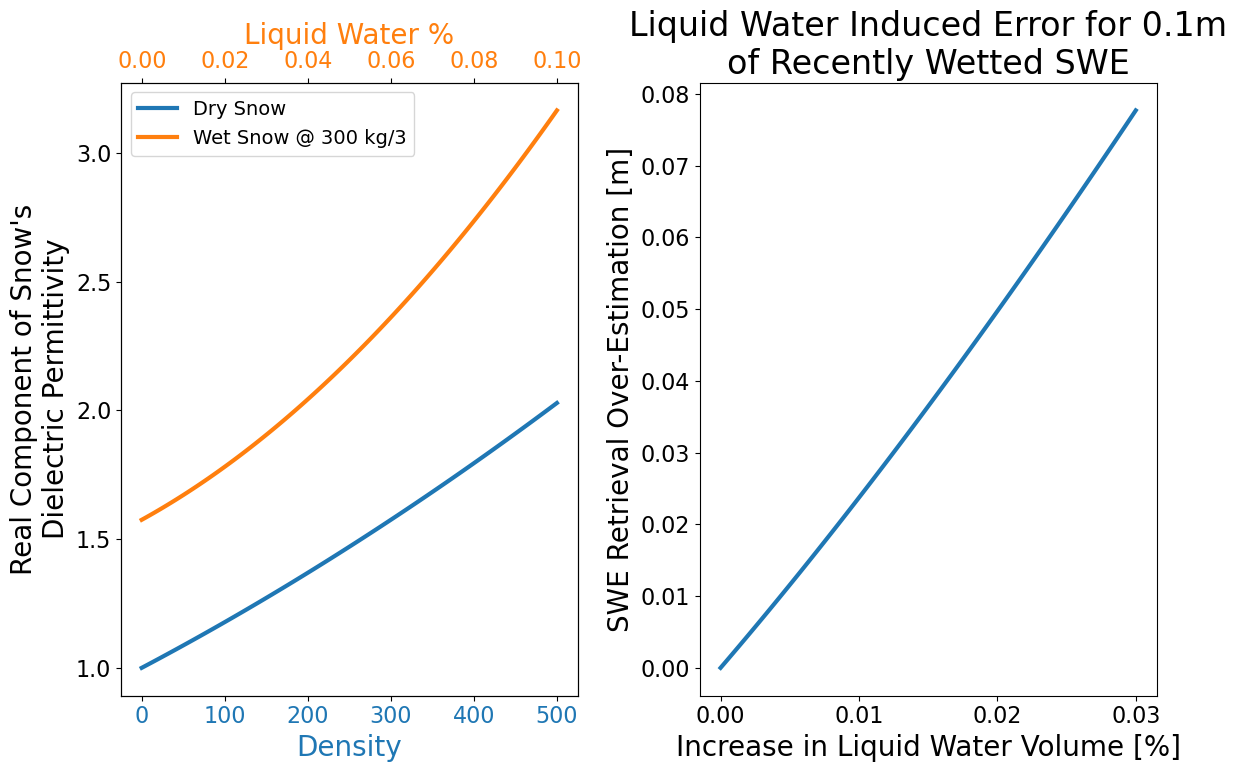

In [10]:
fig, axes = plt.subplots(1, 2, figsize = (12, 8))
density= np.linspace(0, 500, 100)
ax = axes[0]
es_dry = calc_snow_permittivity(density = density)
ax.plot(density, es_dry.real, label = 'Dry Snow')
ax2 = plt.twiny(ax)
wv = np.linspace(0,0.1, 100)
es_wet = calc_snow_permittivity(density = 300, water_vol = wv)# - calc_snow_permittivity(density= pd) # subtract dry snow amount to match figure
ax2.plot(wv, es_wet.real, color = 'C1', label = 'Wet Snow @ 300 kg/3')

ax.set_xlabel('Density', color = 'C0')
ax2.set_xlabel('Liquid Water %', color = 'C1')
[t.set_color('C0') for t in ax.xaxis.get_ticklabels()]
[t.set_color('C1') for t in ax2.xaxis.get_ticklabels()]

lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc=0)
ax.set_ylabel("Real Component of Snow's\nDielectric Permittivity")


hn = np.array([0.5])
inc = np.deg2rad(40)
es_dry = calc_snow_permittivity(density = 250)
phase_dry = phase_from_depth(hn, inc, es_dry.ravel()[0].real)

wv = np.linspace(0,0.03, 100)
es_wet = calc_snow_permittivity(density = 250, water_vol = wv)
phase_wet = phase_from_depth(np.broadcast_to(0.5, wv.shape), inc, permittivity = es_wet.real)
wet_induced_err = depth_from_phase(phase_wet , inc, density = 250) - depth_from_phase(phase_dry, inc, density = 250)

ax = axes[1]
ax.plot(wv, wet_induced_err*250/997)
ax.set_xlabel('Increase in Liquid Water Volume [%]')
ax.set_ylabel('SWE Retrieval Over-Estimation [m]')
ax.set_title(f'Liquid Water Induced Error for {0.5*200/997:.1f}m\nof Recently Wetted SWE')

plt.tight_layout()

plt.savefig('/bsuhome/zacharykeskinen/uavsar-validation/figures/theoretical/wetness_overest.png')

Text(0.5, 1.0, 'Liquid Water Induced Error for Accumulation of 0.2m of Snow @ 250 kg/m3')

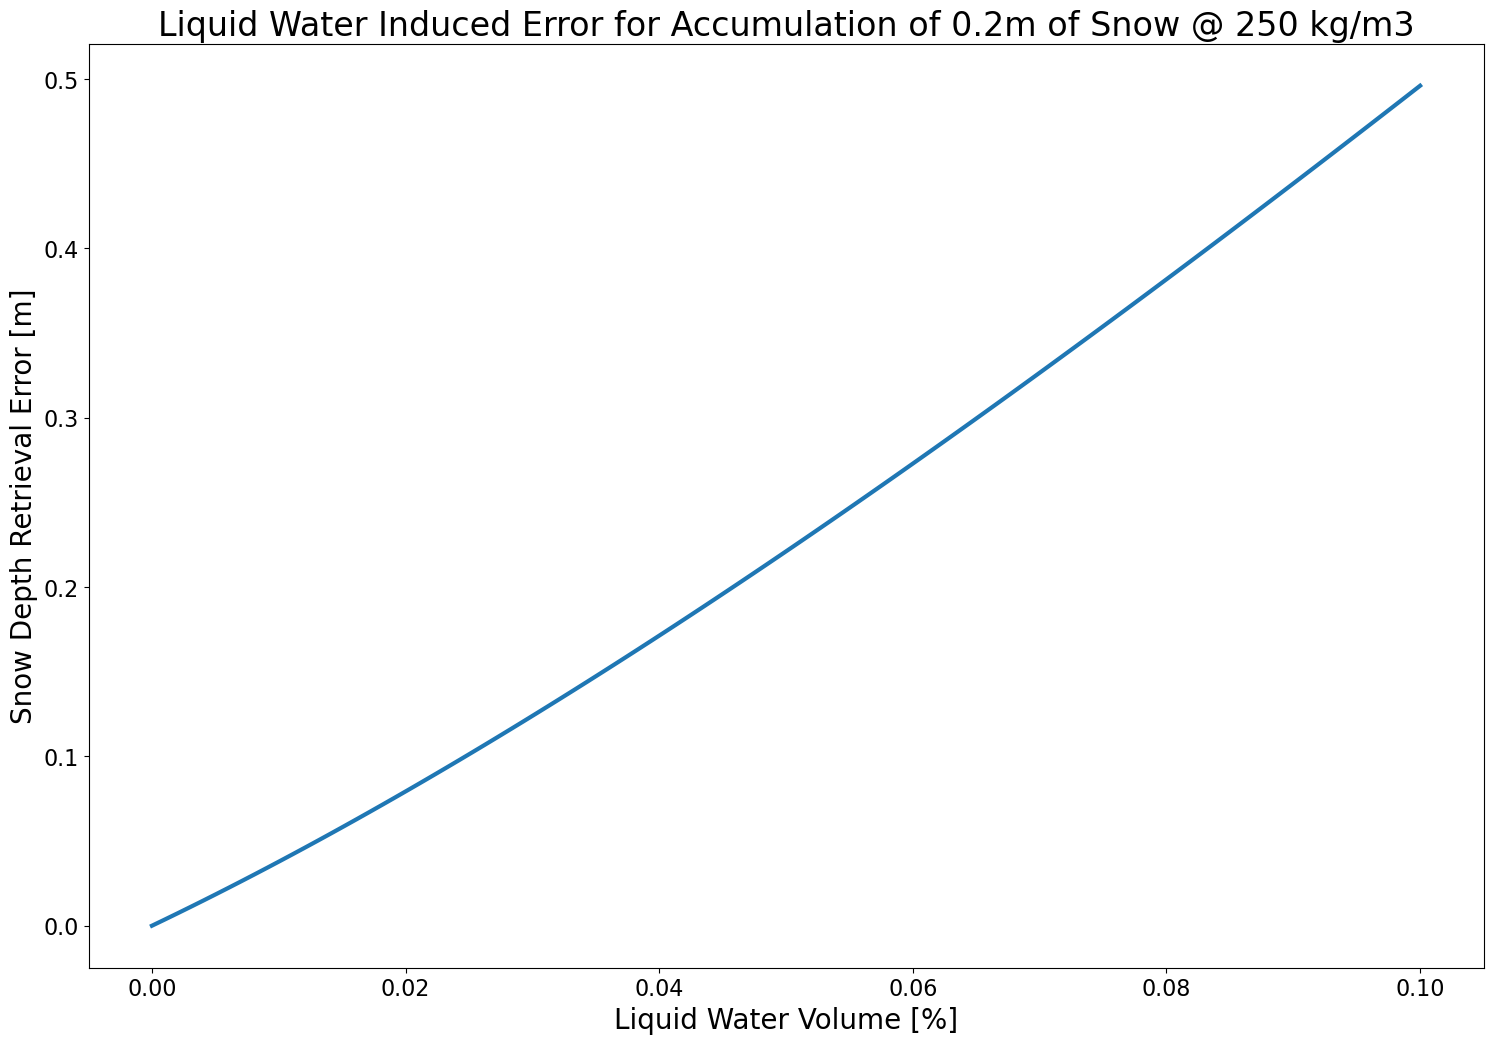

In [11]:
hn = np.array([0.2])
inc = np.deg2rad(40)

fig,ax = plt.subplots()

es_dry = calc_snow_permittivity(density = 250)
phase_dry = phase_from_depth(hn, inc, es_dry.ravel()[0].real)


wv = np.linspace(0,0.1, 100)
es_wet = calc_snow_permittivity(density = 250, water_vol = wv)
phase_wet = phase_from_depth(np.broadcast_to(hn, wv.shape), inc, permittivity = es_wet.real)

wet_induced_err = depth_from_phase(phase_wet - phase_dry, inc, density = 250)

plt.plot(wv, wet_induced_err)
plt.xlabel('Liquid Water Volume [%]')
plt.ylabel('Snow Depth Retrieval Error [m]')
plt.title('Liquid Water Induced Error for Accumulation of 0.2m of Snow @ 250 kg/m3')